## Example matching pump curve to system curve

A Taco model 4013 pump with an 11.25'' impeller operates at 1160 rpm to move water (20$^o$C) a distance of 500 ft through a 5-in diameter cast iron ($\varepsilon$ = 0.00085 ft) pipe to a height of 40 ft.

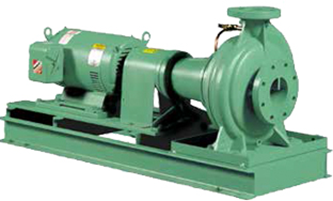

First we need to import all the necessary toolboxes...

In [1]:
# import fsolve from scipy 
from scipy.optimize import fsolve 
# import all the standard math functions and plotting stuff we'd want from numpy and matplotlib
from numpy import*
import matplotlib.pyplot as plt
# This makes the plots appear inside the notebook
%matplotlib inline 

After importing all the necessary toolboxes, we can begin by defining our variables...

In [2]:
## Set your constants
rho = 1.937 # [slug/ft3]
mu = 2.09e-5 # [lb-s/ft2]
d = 5/12   # [ft]
ee = .00085  # [ft] roughness
L = 500  # [ft]
g = 32.2 # [ft/s2]
A = pi/4*d**2
dz = 40  # [ft]

Next we can define our equations and call our solver function. For "fsolve" it's best to rearrange the equations we'll need to solve as follows, noting also that we'll need one Re and one friction factor equation:

Reynolds Number:

$Re = \frac{\rho V d}{\mu}$

Colebrook: 

$0 = -f + \frac{1}{\left(-2 log_{10}\left[\frac{\varepsilon/d}{3.7} + \frac{2.51}{Re_d \sqrt{f} }\right]\right)^2}$

Our energy equation for the system reduces to (where we have no minor losses considered herein):

$\Delta h_{sys} = \frac{V^2}{2g} \left[f \frac{L}{d} + 0 \right]$

...whereas the pump curve can be taken from the mfg curve:

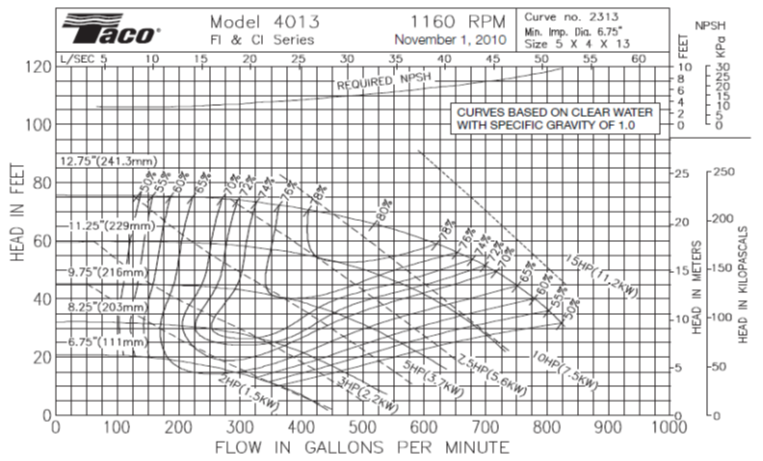

$h_p = -1.5095\times10^{-7}*(VA)_{gpm}^3 + 4.8467\times10^{-7}*(VA)_{gpm}^2 - 6.1781\times10^{-7}*(VA)_{gpm} + 59.840$

...and finally we want to find the point where the pump curve matches the system curve:

$ h_p = h_{sys}

In [3]:
# Define the equations 
def eqns(vars):
    f, V = vars
    Re = rho*V*d/mu # Reynolds Number
    #
    ff = -f + (1/(-2.0*log10(2.51/(Re*sqrt(f)) + (ee/d)/3.7)))**2 # Friction Factor
    #
    hsys = V**2/(2*g)*(f*L/d + (0)) + dz # system equation
    #
    Voldot = V*A*7.48*60 # velocity * area from ft3 to gal/min
    hp = -1.5095e-7*Voldot**3 + 4.8467e-5*Voldot**2 - 6.1781e-3*Voldot + 5.9840e+1 # [ft] pump curve
    #
    eq1 = -hp + hsys
    return [ff, eq1]

# Now call the solver function with some initial guesses
f, V = fsolve(eqns, (0.02, 10))

Qdot = int(V)*A*7.48*60
hp = -1.5095e-7*Qdot**3 + 4.8467e-5*Qdot**2 - 6.1781e-3*Qdot + 5.9840e+1

print("V = %.3f ft/s" % V)
print("VolFlow = %.3f gpm" % Qdot)
print("h_pump = %.3f ft" % hp)

V = 6.045 ft/s
VolFlow = 367.174 gpm
h_pump = 56.634 ft


Now, to better visualize what's going on we can plot the system curve and the pump curve....

In [4]:
Volp = linspace(0.1,1000) # [gpm]
Vp = Volp/7.48/60/A
Rep = rho*Vp*d/mu
hsys_plt = zeros(len(Vp))

for i in range(len(Vp)):
    #build a fxn to find friction factor
    def feqn(f):
        x = -f + (1/(-2.0*log10(2.51/(Rep[i]*sqrt(f)) + (ee/d)/3.7)))**2 # Friction Factor
        return x
    f = fsolve(feqn,0.02) 
    hsys_plt[i] = Vp[i]**2/(2*g)*(f*L/d + (0)) + dz

hp_plt = zeros(len(Volp))
for j in range(len(Volp)):
    hp_plt[j] = -1.5095e-7*Volp[j]**3 + 4.8467e-5*Volp[j]**2 - 6.1781e-3*Volp[j] + 5.9840e+1

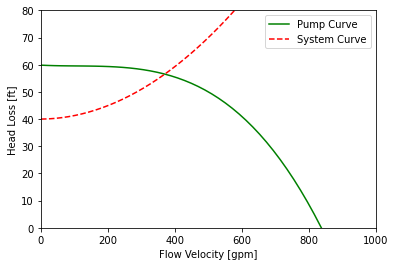

In [7]:
# Plotting the data
fig, ax = plt.subplots()
ax.plot(Volp,hp_plt,'g')
ax.plot(Volp,hsys_plt,'--r')
# Plot specifics
ax.set_xlabel('Flow [gpm]')
ax.set_ylabel('Head Loss [ft]')
ax.legend(['Pump Curve', 'System Curve','Location','northwest'])
ax.set_xlim([0, 1000])
ax.set_ylim([0, 80])
plt.show()